In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [2]:
def Conv_block(data, train=True, filter1=3, filter2=3, maxpool=True, std =1, in_ch=3, out_ch=3):    
    
    
    conv1 = tf.layers.conv2d(data, filters=out_ch,kernel_size=filter1, strides=std, padding="SAME", trainable=train)
    output = tf.layers.conv2d(conv1, filters=out_ch,kernel_size=filter2, strides=1, padding='SAME',trainable=train)
    if maxpool:
        output = tf.layers.max_pooling2d(inputs = output, pool_size=2, strides=2, padding='VALID')
    
    return output

In [3]:
def Upsample_block(data, output_size, kernel=2, std=2):
    
    output = tf.layers.conv2d_transpose(data, filters=output_size, kernel_size=kernel, strides=std, padding="VALID")
    
    return output

In [4]:
def Model(data, train, batch_size):

    
    
    with tf.variable_scope("conv1"):
        Conv1_feature = Conv_block(data, train, filter1=7, filter2=3, maxpool=True, std=2,in_ch=3,out_ch=8)
        Conv1_feature = tf.slice(Conv1_feature,[0,0,0,0],[batch_size,268,480,8])
        print("Conv1 Done")

    with tf.variable_scope("conv2"):
        Conv2_feature = Conv_block(Conv1_feature, train, filter1=7, filter2=3, maxpool=True, in_ch=8,out_ch=16)
        print("Conv2 Done")
    with tf.variable_scope("conv3"):
        Conv3_feature = Conv_block(Conv2_feature, train, filter1=7, filter2=3, maxpool=True, in_ch=16,out_ch=32)
        print("Conv3 Done")
        
     
    
    upsize = Conv1_feature.get_shape().as_list()[-1]      
    with tf.variable_scope("Upsize1"):
        Conv2_up = Upsample_block(Conv2_feature, upsize, kernel=2, std=2)        
        print("Upsize1 Done")
    with tf.variable_scope("Upsize2"):
        upsize2 = Conv2_feature.get_shape().as_list()[-1]
        Conv3_up = Upsample_block(Conv3_feature, upsize, kernel=4, std=4)
        print("Upsize2 Done")
        '''bias = tf.zeros([batch_size, 2, 480, 8])
        Conv3_up = tf.concat([Conv3_up, bias], axis=1)'''

        
        
    with tf.variable_scope("Concat_conv"):
        Conv_concat = tf.concat([Conv1_feature, Conv2_up, Conv3_up],axis=3)  
        print("Concat Done")
    with tf.variable_scope("conv4"):
        Conv4_feature = Conv_block(Conv_concat, train, filter1=7, filter2=3, maxpool=False, in_ch = 56,out_ch=2)
        print("Conv4 Done")
        #print(Conv4_feature)


    return Conv4_feature

In [5]:
def optimizer(data):
    #print(data)
    logits = tf.nn.softmax(data)
    print("lgits done")
    
    return logits
    

In [6]:
#Test_Image Data List Load

Test_file = "./Deep_Ball_Result/Test.txt"
Image_list = []

f = open(Test_file)
while True:
    line = f.readline()
    if not line: break
    Image_list.append(line[:-1])
f.close()

In [8]:
# Image Load

#img_name  = Image_list[156]
img_name = "./DataSet(190408)/Free_A/Parse_Data/00005/0/Free1 (3).jpg"
im = []

img =cv2.imread(img_name)
img = cv2.resize(img, (1920,1080))
b, g, r = cv2.split(img)
img = (cv2.merge([r,g,b]))
img = np.expand_dims(img, axis =0)

In [9]:
train=False
batch_size = 1
save_file = "./Deep_Ball_Result/Deep_Ball_Model_69_8000.ckpt"
tf.reset_default_graph()


input_image = tf.placeholder(tf.float32,[None, 1080, 1920, 3])

init = tf.global_variables_initializer()


with tf.Session(config=tf.ConfigProto(gpu_options=(tf.GPUOptions(per_process_gpu_memory_fraction=0.7)), log_device_placement=True)) as sess:
    
    
    output = Model(input_image, train, batch_size)
    
    logits = optimizer(output)
    
    
    saver = tf.train.Saver(max_to_keep = 8000000)
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    saver.restore(sess, save_file)
    
    output = sess.run(logits, feed_dict ={input_image : img})
    output = np.argmax(output[0], axis = 2)

Conv1 Done
Conv2 Done
Conv3 Done
Upsize1 Done
Upsize2 Done
Concat Done
Conv4 Done
lgits done
INFO:tensorflow:Restoring parameters from ./Deep_Ball_Result/Deep_Ball_Model_69_8000.ckpt


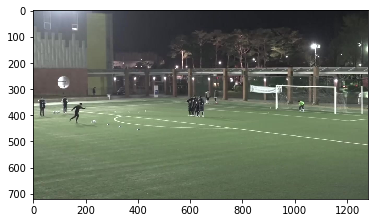

In [10]:
vis_img =cv2.imread(img_name)
b, g, r = cv2.split(vis_img)
vis_img = (cv2.merge([r,g,b]))
plt.imshow(vis_img)

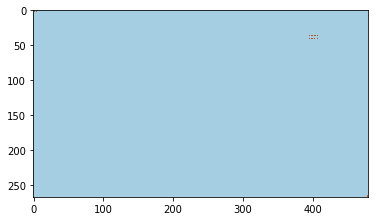

In [11]:
plt.imshow(output, cmap=cm.Paired)

In [12]:
np.nonzero(output)

(array([  1,   1,   2,   2,   2,  36,  36,  36,  36,  36,  36,  40,  40,
         40,  40,  40,  40, 100, 100, 100, 100, 108, 265, 266, 266, 267],
       dtype=int64),
 array([  1,   5,   1,   2,   5, 396, 399, 400, 403, 404, 407, 396, 399,
        400, 403, 407, 475, 343, 344, 347, 348, 475, 479, 478, 479, 479],
       dtype=int64))

In [13]:
resize_img = cv2.resize(vis_img, (480,268))
for i,x in  enumerate(np.nonzero(output)[0]):
    resize_img[x,np.nonzero(output)[1][i]] = [255,0,0]


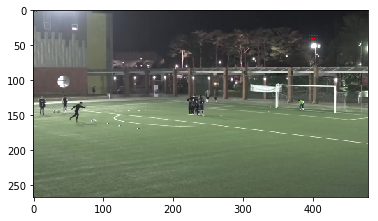

In [14]:
plt.imshow(resize_img)